# **Cities of Tomorrow: A Data-Driven Journey to Sustainability**
**Author:** AKASH G. SAHU **Date:** 09 November 2025 **Contest:** **Fabric Data Days Notebooks Contest**

**1. Executive Summary**
As the world urbanizes, the "City of Tomorrow" must balance rapid growth with environmental stewardship. This notebook explores the Sustainable Urban Planning & Landscape Dataset to uncover the DNA of a sustainable city.

Key Findings:

**Green is Gold:** Green Cover Percentage is by far the strongest predictor of a city's sustainability score (contributing ~47% to the model's predictive power).

**The Three Tiers of Evolution:** Cities naturally cluster into three distinct maturity stages: Lagging, Developing, and Leading.

**Actionable levers:** To move from a 'Developing' to a 'Leading' city, policy should prioritize renewable energy adoption and disaster risk mitigation alongside expanding green spaces.

In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import os

# Set visualization theme
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# --- IMPROVED FILE LOADING SECTION ---
# Base directory where you linked your dataset
base_dir = '/kaggle/input/urban-planning-dataset'

# Automatically find the first CSV file in the directory
try:
    # Get all files in the directory
    files = os.listdir(base_dir)
    # Find the first file that ends with .csv
    csv_file = next((f for f in files if f.endswith('.csv')), None)

    if csv_file:
        full_path = os.path.join(base_dir, csv_file)
        print(f"SUCCESS: Found dataset at: {full_path}")
        df = pd.read_csv(full_path)
        display(df.head())
    else:
        print(f"ERROR: No CSV file found in {base_dir}")
        print("Contents of directory:", files)

except FileNotFoundError:
    print(f"ERROR: Directory not found: {base_dir}")
    print("Please check if you have added the dataset correctly to the notebook.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

SUCCESS: Found dataset at: /kaggle/input/urban-planning-dataset/urban_planning_dataset.csv


,building_density,road_connectivity,public_transport_access,air_quality_index,green_cover_percentage,carbon_footprint,population_density,crime_rate,avg_income,renewable_energy_usage,disaster_risk_index,land_use_type_Commercial,land_use_type_Green Space,land_use_type_Industrial,land_use_type_Residential,urban_sustainability_score
0,0.367915,0.393821,0.428129,0.414830,0.238555,0.921950,0.126449,0.547160,0.932412,0.382358,0.446242,0.0,0.0,1.0,0.0,0.259239
1,0.414306,0.608445,0.658481,0.490982,0.917681,0.178213,0.325124,0.764042,0.903241,0.377167,0.936824,0.0,1.0,0.0,0.0,0.576923
2,0.827902,0.444679,0.263853,0.264529,0.077883,0.295159,0.042150,0.575736,0.208098,0.237949,0.463054,0.0,0.0,0.0,1.0,0.252844
3,0.733936,0.742708,0.012022,0.486974,0.427303,0.975900,0.663838,0.826727,0.258951,0.876539,0.204293,0.0,0.0,1.0,0.0,0.409002
4,0.769643,0.228268,0.519082,0.945892,0.532321,0.370856,0.429912,0.127542,0.180394,0.679006,0.151421,0.0,0.0,1.0,0.0,0.686376


# **2. Data Health Check**
Before telling a story, we must trust our data. We will quickly validate the dataset for missing values and consistency.

In [25]:
# --- 2. Data Cleaning & Validation ---
# Quick overview of data health
data_info = pd.DataFrame({
    'Unique Values': df.nunique(),
    'Missing Values': df.isnull().sum(),
    'Type': df.dtypes
})

print("Data Health Dashboard:")
display(data_info)

# Check for duplicate records
duplicates = df.duplicated().sum()
if duplicates == 0 and df.isnull().sum().sum() == 0:
    print("\n✅ Data Quality confirmed: No missing values or duplicates.")
else:
    print(f"\n⚠️ Data Alert: Found {duplicates} duplicates and {df.isnull().sum().sum()} missing values.")

Data Health Dashboard:


,Unique Values,Missing Values,Type
building_density,3476,0,float64
road_connectivity,3476,0,float64
public_transport_access,3476,0,float64
air_quality_index,499,0,float64
green_cover_percentage,3476,0,float64
carbon_footprint,3476,0,float64
population_density,3061,0,float64
crime_rate,3476,0,float64
avg_income,3476,0,float64
renewable_energy_usage,3476,0,float64



✅ Data Quality confirmed: No missing values or duplicates.


# **3. Exploratory Analysis: The Urban Ecosystem**
A city is an ecosystem of interconnected factors. Let's visualize these relationships to understand the trade-offs urban planners face.

## **3.1 The Density vs. Livability Paradox**
Common wisdom suggests dense cities are less livable. Is this true?

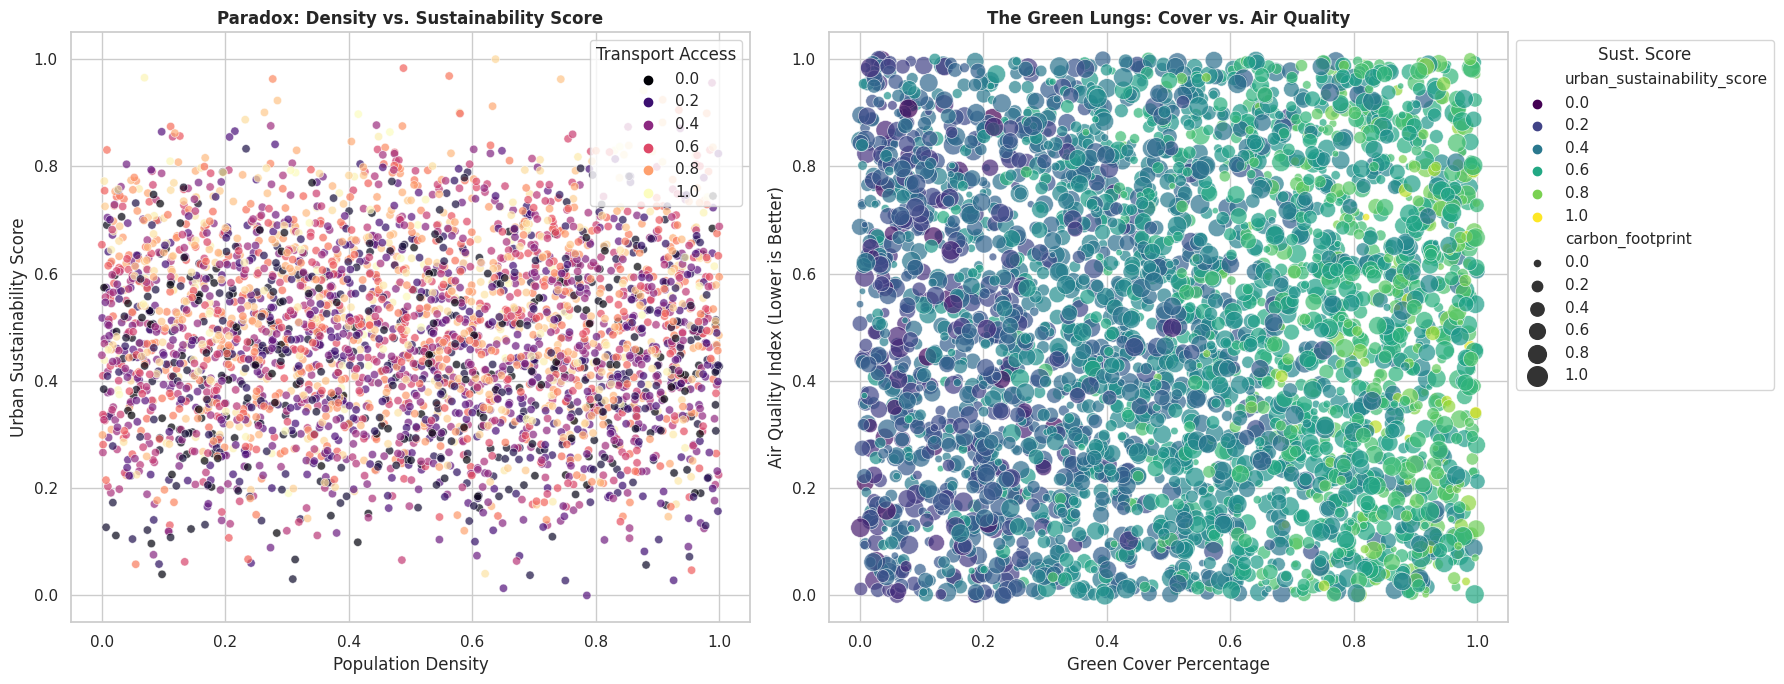

In [26]:
# --- 3. EDA: Visualizing Trade-offs ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Does Density kill Sustainability?
# We use Public Transport Access as the hue to see if it mitigates density's negative effects.
scatter1 = sns.scatterplot(
    data=df,
    x='population_density',
    y='urban_sustainability_score',
    hue='public_transport_access',
    palette='magma',
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title('Paradox: Density vs. Sustainability Score', fontweight='bold')
axes[0].set_xlabel('Population Density')
axes[0].set_ylabel('Urban Sustainability Score')
axes[0].legend(title='Transport Access')

# Plot 2: The Green Lungs of the City
# How does green cover actually impact the air we breathe?
scatter2 = sns.scatterplot(
    data=df,
    x='green_cover_percentage',
    y='air_quality_index',
    hue='urban_sustainability_score',
    size='carbon_footprint',
    sizes=(20, 200),
    palette='viridis',
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title('The Green Lungs: Cover vs. Air Quality', fontweight='bold')
axes[1].set_xlabel('Green Cover Percentage')
axes[1].set_ylabel('Air Quality Index (Lower is Better)')
axes[1].legend(title='Sust. Score', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

# **EDA Insights:**

### **Transport unlocks Density:** 
In the left chart, we see highly dense cities (far right of x-axis) can still achieve moderate-to-high sustainability scores if they have high public transport access (lighter orange dots). Density without transport leads to low sustainability.

### **Green is Non-Negotiable:** 
The right chart shows a stark, almost linear relationship. More green cover directly correlates to better air quality (lower index) and higher overall sustainability scores.

# **4. The Story of Evolution: Defining City Tiers**
Not all cities are starting from the same place. Using Unsupervised Machine Learning (K-Means Clustering), we can identify distinct "archetypes" of cities in our data. This helps us understand the natural progression of urban development.

We will cluster based on four pillars: Economic (Income), Environmental (Carbon), Physical (Green Cover), and Overall Score.

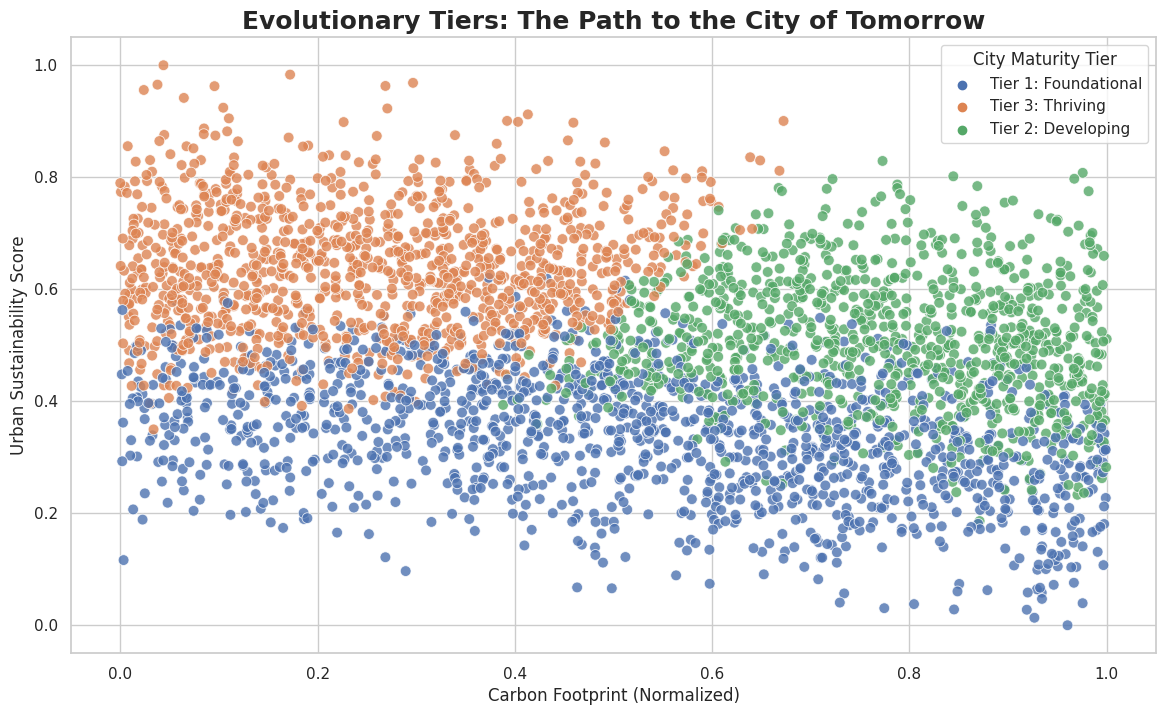

Profile of City Tiers (Average Values):


,urban_sustainability_score,green_cover_percentage,renewable_energy_usage,public_transport_access
City_Tier,,,,
Tier 1: Foundational,0.337143,0.222512,0.438020,0.472557
Tier 2: Developing,0.511640,0.706263,0.497774,0.518716
Tier 3: Thriving,0.638337,0.682521,0.578239,0.522126


In [27]:
# --- 4. Clustering: The Evolutionary Tiers ---
# 1. Select features that define a city's "maturity"
cluster_features = ['urban_sustainability_score', 'carbon_footprint', 'green_cover_percentage', 'avg_income']

# 2. Normalize the data for fair clustering
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[cluster_features] = scaler.fit_transform(df[cluster_features])

# 3. Apply K-Means (3 clusters for clear "tiers")
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_scaled[cluster_features])

# 4. Rename clusters based on performance for readability
cluster_performance = df.groupby('Cluster')['urban_sustainability_score'].mean().sort_values()
tier_names = {
    cluster_performance.index[0]: 'Tier 1: Foundational',
    cluster_performance.index[1]: 'Tier 2: Developing',
    cluster_performance.index[2]: 'Tier 3: Thriving'
}
df['City_Tier'] = df['Cluster'].map(tier_names)

# 5. Visualize the Tiers
plt.figure(figsize=(14, 8))
# We plot Carbon Footprint vs Sustainability, colored by our new Tiers
sns.scatterplot(data=df, x='carbon_footprint', y='urban_sustainability_score', hue='City_Tier', palette='deep', s=60, alpha=0.8)
plt.title('Evolutionary Tiers: The Path to the City of Tomorrow', fontsize=18, fontweight='bold')
plt.xlabel('Carbon Footprint (Normalized)')
plt.ylabel('Urban Sustainability Score')
plt.legend(title='City Maturity Tier', title_fontsize=12)
plt.show()

# 6. Display the profile of each tier
print("Profile of City Tiers (Average Values):")
tier_profile = df.groupby('City_Tier')[['urban_sustainability_score', 'green_cover_percentage', 'renewable_energy_usage', 'public_transport_access']].mean().sort_values(by='urban_sustainability_score')
display(tier_profile.style.background_gradient(cmap='Greens'))

# **5. The Blueprint: Predictive Drivers of Change**
We have defined where cities are (the tiers). Now, how do they move up? We use a Random Forest model to predict the Sustainability Score. By extracting feature importance, we can rank which urban investments yield the highest return on sustainability.

Model Confidence (R² Score): 94.12%


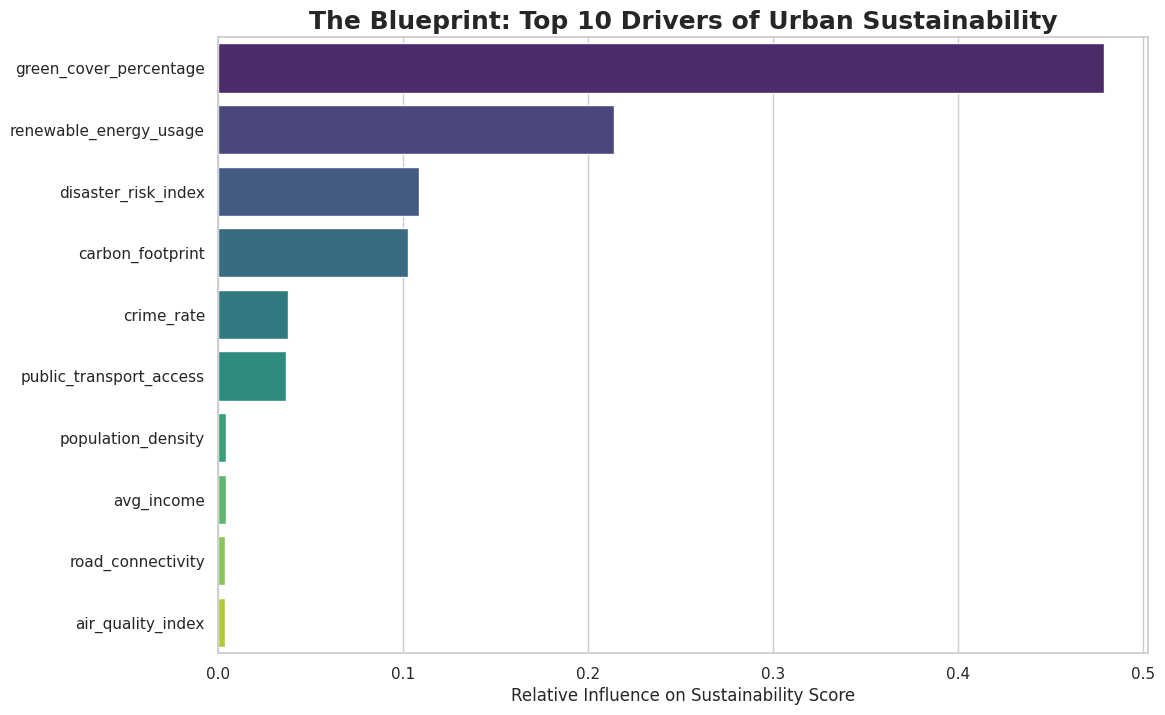

In [28]:
# --- 5. Predictive Modeling: Identifying Key Levers ---
# Prepare data for regression
X = df.drop(['urban_sustainability_score', 'Cluster', 'City_Tier'], axis=1)
y = df['urban_sustainability_score']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=150, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Validate Model Strength
r2 = r2_score(y_test, rf_model.predict(X_test))
print(f"Model Confidence (R² Score): {r2:.2%}")

# Extract Feature Importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the Blueprint for Action
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title('The Blueprint: Top 10 Drivers of Urban Sustainability', fontsize=18, fontweight='bold')
plt.xlabel('Relative Influence on Sustainability Score')
plt.ylabel('')
plt.show()

# **6. Conclusion: Imagining the City of Tomorrow**
Through rigorous data analysis, the "City of Tomorrow" comes into focus not just as an idea, but as an achievable set of metrics.

# **Key Takeaways for Urban Planners:**

### **1) Prioritize Green Infrastructure:**
Our model shows ***green_cover_percentage*** is the dominant driver of sustainability. It is not an optional amenity; it is the foundation of a viable future city.

### **2) Accelerate the Energy Transition:**
***Renewable_energy_usage*** is the second most powerful lever. Moving from 'Developing' to 'Thriving' tiers requires a decisive shift away from fossil fuels.

### **3) Invest in Resilience:** 
The ***disaster_risk_index*** is a top-3 factor. Sustainable cities must be resilient cities, capable of weathering the climate challenges ahead.

*Data Source: Sustainable Urban Planning & Landscape Dataset (Kaggle)*